In [35]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.0-preview2-bin-hadoop2.7/
spark-3.0.0-preview2-bin-hadoop2.7/data/
spark-3.0.0-preview2-bin-hadoop2.7/data/streaming/
spark-3.0.0-preview2-bin-hadoop2.7/data/streaming/AFINN-111.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_binary_classification_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_kmeans_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_multiclass_classification_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_lda_libsvm_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/iris_libsvm.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/pagerank_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_linear_regression_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/pic_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/test.data
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/sample_movielens_rati

In [0]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [0]:
spark = SparkSession.builder.getOrCreate()

In [0]:
msNPC = spark.read.option("inferSchema", "true").csv("MsNPC.csv", header=True)
msPlayer = spark.read.option("inferSchema", "true").csv("MsPlayer.csv", header=True)
msWeapon = spark.read.option("inferSchema", "true").csv("MsWeapon.csv", header=True)
msWeaponType = spark.read.option("inferSchema", "true").csv("MsWeaponType.csv", header=True)
transactionDetail = spark.read.option("inferSchema", "true").csv("TransactionDetail.csv", header=True)
transactionHeader = spark.read.option("inferSchema", "true").csv("TransactionHeader.csv", header=True)

In [0]:
msNPC.createOrReplaceTempView("MsNPC")
msPlayer.createOrReplaceTempView("MsPlayer")
msWeapon.createOrReplaceTempView("MsWeapon")
msWeaponType.createOrReplaceTempView("MsWeaponType")
transactionDetail.createOrReplaceTempView("TransactionDetail")
transactionHeader.createOrReplaceTempView("TransactionHeader")

In [0]:
case1 = spark.sql("""
    SELECT mwt.WeaponTypeName, SUM(td.Quantity * mw.WeaponPrice) AS `WeaponRevenue`
    FROM MsWeaponType mwt
    JOIN MsWeapon mw ON mw.WeaponTypeId = mwt.WeaponTypeId
    JOIN TransactionDetail td ON td.WeaponId = mw.WeaponId
    JOIN TransactionHeader th ON th.TransactionId = td.TransactionId
    WHERE YEAR(th.TransactionDate) = "2019"
    GROUP BY mwt.WeaponTypeName
    ORDER BY mwt.WeaponTypeName DESC
""")

In [0]:
case1 = case1.toPandas()


<function matplotlib.pyplot.show>

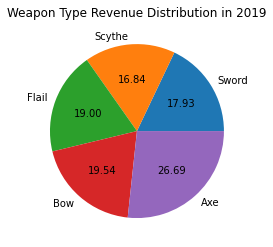

In [67]:
plt.title("Weapon Type Revenue Distribution in 2019")
plt.pie(case1['WeaponRevenue'],
        labels = case1['WeaponTypeName'],
        autopct = "%.2f")
plt.show

In [0]:
case2 = spark.sql("""
    SELECT Month, COUNT(PlayerId) as `PlayerCount`
    FROM (
    SELECT DISTINCT MONTH(th.TransactionDate) as `Month`, th.PlayerId
    FROM TransactionHeader th 
    JOIN TransactionDetail td ON th.TransactionId = td.TransactionId
    JOIN MsWeapon mw ON mw.WeaponId = td.WeaponId
    JOIN MsWeaponType mwt ON mwt.WeaponTypeId = mw.WeaponTypeId
    WHERE mwt.WeaponTypeName = "Axe" AND YEAR(th.TransactionDate) = "2019"
    ORDER BY Month ASC
    ) x
    GROUP BY Month
    ORDER BY Month 
""")

In [0]:
case2 = case2.toPandas()

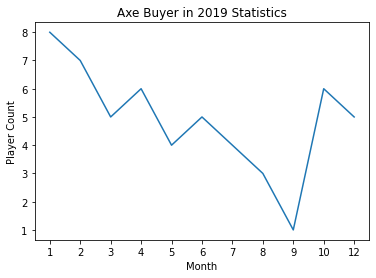

In [201]:
plt.title("Axe Buyer in 2019 Statistics")
plt.plot (case2['PlayerCount'])
plt.xticks (range(len(case2['Month'])), case2['Month'])
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

In [0]:
case3 = spark.sql("""
  SELECT WeaponName, COUNT(WeaponName) as `Frequency`
  FROM
    (
    SELECT PlayerId, PlayerName, 
      CASE
        WHEN Spending BETWEEN 1000000 AND 1499999 THEN 'Storm Breaker'
        WHEN Spending BETWEEN 1500000 AND 1999999 THEN 'Nightfall'
        WHEN Spending > 2000000 THEN 'Extinction'
      END 
        AS `WeaponName`
    FROM (
        SELECT mp.PlayerId, mp.PlayerName, SUM(Quantity * WeaponPrice) as `Spending`, MONTH(th.TransactionDate) as `Month`
        FROM MsWeapon mw
        JOIN TransactionDetail td ON mw.WeaponId = td.WeaponId
        JOIN TransactionHeader th ON th.TransactionId = td.TransactionId
        JOIN MsPlayer mp ON mp.PlayerId = th.PlayerId
        WHERE mp.PlayerGender = "Female" AND YEAR(th.TransactionDate) = "2019"
        GROUP BY mp.PlayerId, mp.PlayerName, Month
        ORDER BY Month ASC
        ) x
      ) y
    GROUP BY WeaponName
    LIMIT 3
""")

In [0]:
case3 = case3.toPandas()

In [0]:
plt.bar(case3['WeaponName'], case3['Frequency'])
plt.title("Frequency of Special Weapon distributed to Female Player in 2019")
plt.xlabel("Weapon Name")
plt.ylabel("Frequency")
plt.show()

In [0]:
case4 = spark.sql("""
  SELECT Month, COUNT(PlayerId) as `PlayerCount`
    FROM (
    SELECT MONTH(TransactionDate) as `Month`, PlayerId, COUNT(WeaponTypeName) as `WeaponCount`
    FROM (
      SELECT DISTINCT th.TransactionDate, th.PlayerId, mwt.WeaponTypeName
      FROM 
      TransactionHeader th 
      JOIN TransactionDetail td ON th.TransactionId = td.TransactionId
      JOIN MsWeapon mw ON mw.WeaponId = td.WeaponId
      JOIN MsWeaponType mwt ON mwt.WeaponTypeId = mw.WeaponTypeId
      WHERE YEAR(th.TransactionDate) = "2019"
    ) x 
    GROUP BY Month, PlayerId
    HAVING WeaponCount >= 3
    ORDER BY Month ASC
    ) y
  GROUP BY Month
  ORDER BY Month ASC
""")

In [0]:
case4 = case4.toPandas()

In [0]:
plt.title("Players in 2019 Who Bought At Least 3 Different Weapon Type in a Month")
plt.plot (case4['PlayerCount'])
plt.xticks (range(len(case4['Month'])), case4['Month'])
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

In [0]:
case5 = spark.sql("""
    SELECT Popularity, COUNT(Popularity) AS `Frequency`
    FROM (
      SELECT NPCId, 
      CASE
        WHEN TotalIncome >= 15000000 THEN 'Very Popular'
        WHEN TotalIncome BETWEEN 7500000 AND 14999999 THEN 'Popular'
        WHEN TotalIncome BETWEEN 2499999 AND 7499999 THEN 'Quite Popular'
        ELSE 'Not Popular'
      END AS `Popularity`
      FROM (
      SELECT COUNT(PlayerID) as `PlayerCount`, NPCId, SUM(Income) as `TotalIncome`
      FROM (
      SELECT th.PlayerId, th.NPCId, SUM(td.Quantity * mw.WeaponPrice) as `Income`
      FROM 
      TransactionHeader th 
      JOIN TransactionDetail td ON th.TransactionId = td.TransactionId
      JOIN MsWeapon mw ON mw.WeaponId = td.WeaponId
      GROUP BY th.PlayerId, th.NPCId
      ) x
      GROUP BY NPCId
      HAVING PlayerCount >= 5
      ) y
    ) z
    GROUP BY Popularity
""")

In [0]:
case5 = case5.toPandas()

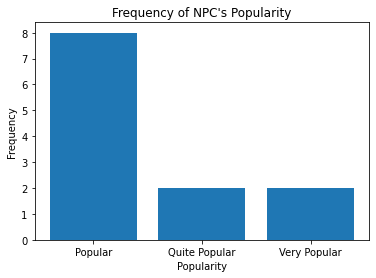

In [273]:
plt.bar(case5['Popularity'], case5['Frequency'])
plt.title("Frequency of NPC's Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()